# DNN 深度神經網路 手寫辨識

## 設定層數與神經元數量

在此設定將 4 層的深度學習, 其中設定每一層的神經元個數
- 第一層 N1 = 256
- 第二層 N2 = 128
- 第三層 N3 = 64
- 第四層 N4 = 32

這樣設定的目的是為了逐步壓縮資料特徵，減少過度擬合的風險。

In [13]:
N1 = 256
N2 = 128
N3 = 64
N4 = 32

## 1. 讀入 "Gradio" 套件

此 Python 套件的目的是快速測試和展示深度學習、機器學習模型，並建立互動式的介面。

In [ ]:
%pip install gradio

  Using cached gradio-5.25.0-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached gradio_client-1.8.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached orjson-3.10.16-cp311-cp311-macosx_10_15_x86_64.macosx_11_0_arm64.macosx_10_15_universal2.whl.metadata (41 kB)
  Using cached pydantic-2.11.3-py3-none-any.whl.metadata (65 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.11.5-py3-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.46.1-py3-none-any.whl.metadat

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

from ipywidgets import interact_manual

import gradio as gr

## 2. MNIST 數據庫

MNIST 是一個手寫數字數據集，是 ML 和 Deep Learning 領域最常用的入門數據集之一。它包含 0~9 的手寫數字，用來訓練和測試圖像分類模型。
- 訓練集：60,000 張 28×28 的灰階手寫數字圖片與標籤
- 測試集：10,000 張 28×28 的灰階手寫數字圖片與標籤
- 標籤：數字 0 到 9（共 10 類）
- 每張圖片像素值範圍是 0~255

### 2.1 由 Keras 讀取數據集

上方程式碼中的 tensorflow.keras.datasets 提供的內建 MNIST 數據集，可以直接載入使用。

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### 以下確認資料格式：
- ### 訓練集與測試及分別為 60000、10000 張

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### 2.2 數據庫的內容

- x 為 0~9 中某數字的圖檔, 格式為 28*28
- y 為給定正解

In [5]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'訓練集 y 中的答案為: {y_train[n]}')

### 2.3 整理輸入格式

為了要讓自行建立的標準神經網路學習手寫辨識。需要將原先 28*28 的矩陣型態轉換成長度為 784 的向量。

因此需要 reshape 數入資料的格式。

而每張圖片的像素質為 0 ~ 255 之間，通常加入一個步驟為 Normalization 將數字縮小至 0 ~ 1 之間。

### 以下程式碼提供觀察訓練集中的 x 圖片以及 y 正確答案。


interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

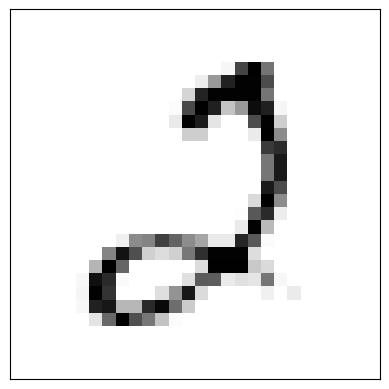

In [6]:
interact_manual(show_xy, n=(0,59999));

### 以下程式碼將資料格式轉換為長度 784 的向量並做 normalization


In [7]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255
print(x_train.shape)

(60000, 784)


### 2.4 輸出格式整理（One-Hot Encoding）
在此需要 One-Hot Encoding ，以避免數值大小的誤導

如果標籤是 0, 1, 2, 3，神經網路可能會認為 3 比 0「大」，但這其實沒有意義。

One-Hot Encoding 能確保每個類別彼此獨立，沒有數值大小關係，且適用於分類問題。

方便的是 Keras 已具備套件可以幫助完成此編碼。

In [8]:
y_train[5678]

5

### 以上觀察 y_train 其中一個答案為 5


In [9]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [10]:
n = 5678
y_train[n]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

### 以上反應壓縮成 10 維的向量後，觀察到第 6 個位置是 '1' 代表答案為 5

## 3. 建立神經網路

使用標準神網路，需要設定：
- 隱藏層數量
- 各層神經元數量
- 激發函數為何？（例如 ReLU）

### 3.1 設定神經網路

使用 `Sequential`, 打開一個神經網路。

In [11]:
model = Sequential()

TensorFlow 不知道輸入的長度為 784 個維度，因此在第一個隱藏層要告訴它。

In [14]:
model.add(Dense(N1, input_dim=784, activation='relu'))

/Users/andrewhsu/Documents/生成式AI/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


第二層後，不需要再說明輸入神經元個數。

此神經網路設定為總共 4 層，且激發函數為 "ReLU"

In [15]:
model.add(Dense(N2, activation='relu'))

In [16]:
model.add(Dense(N3, activation='relu'))

In [17]:
model.add(Dense(N4, activation='relu'))

以上程式碼中，最後 "softmax" 為一個激活函數，於將輸出的數值轉換為機率分布，

因為此為分類問題，因此 0~9 中的 10 個類別機率相加要為1，如下式

$$\sum_{i=1}^{10} y_i = 1$$


In [18]:
model.add(Dense(10, activation='softmax')) #此為固定

至此我們的第一個神經網路就建好了!

### 3.2 Compile 神經網路
因為這個神經網路對應的為分類問題，且又經過 One-Hot Encoding 的轉換，
因此這邊更改以下設定：

* 損失函數：交叉熵損失（Cross-Entropy Loss）；原先的 MSE 較適合迴歸問題
* optimizer："Adam" ；其學習較快速、穩定
* 若使用 "Adam" 則不需要指定 learning rate

In [19]:
model.compile(loss='categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])

## 4. 檢視神經網路

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

以上表格顯示，此神經網路是一個 5 層全連接的分類模型。隱藏層依次為 256、128、64、32 個神經元，輸出層為 10 個神經元，使用 softmax 進行數字分類。
總參數數量為 244,522 且皆可訓練。

## 5. 訓練神經網路

在此設定以下訓練參數：
* `batch_size` = 100
* `epochs` =  20

In [21]:
model.fit(x_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8443 - loss: 0.5252
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9647 - loss: 0.1146
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9781 - loss: 0.0689
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9856 - loss: 0.0467
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9869 - loss: 0.0399
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9903 - loss: 0.0306
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9923 - loss: 0.0250
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9930 - loss: 0.0227
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9935 - loss: 0.0205
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0169
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9951 - loss: 0.0153
Epoch 12/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

## 6. 測試訓練結果

以下為評估模型在測試集的表現：

- 準確率 98.18%   → 模型在測試集的表現不錯
- 平均損失 0.1204  → 模型的預測誤差相對較小

In [22]:
loss, acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9768 - loss: 0.1133


In [23]:
print(f"測試資料正確率 {acc*100:.2f}%")

測試資料正確率 97.93%


### 為了要讓圖形顯示，需要將 `x_test` 中的資料轉換回 28x28 的矩陣

In [28]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    prediction = model.predict(x_test[測試編號].reshape(1, 784))
    print('神經網路判斷為:', prediction.argmax())

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

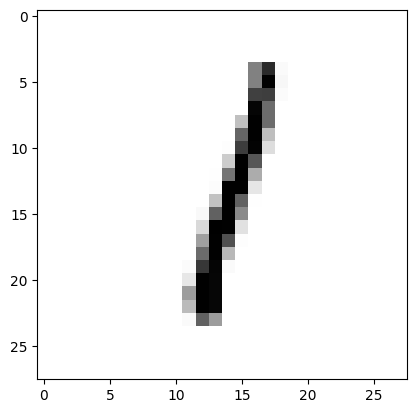

In [30]:
interact_manual(test, 測試編號=(0, 9999));

### 7. 使用 Gradio 來展示神經網路訓練結果

In [31]:
def resize_image(inp):
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    image_pil = Image.fromarray(image)

    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3])
    image_pil = background

    image_gray = image_pil.convert("L")

    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    img_array = 255 - img_array

    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [32]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [33]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://35b151423e17cdba23.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://35b151423e17cdba23.gradio.live
